In [1]:
# include("src/ROCAnalysis.jl")

In [2]:
using ROCAnalysis

This package analyses the results of a probabilistic binary classifier.  We'll assume that the classifier generates scores that tend to be higher towards the "target" class, and lower towards the "non-target" class.  

In this notebook we will simulate the scores, by generating them from two separate distributions.  We'll do this in a way that the scores can be considered _well-calibrated log-likelihood-ratio_ scores, i.e., the scores are supposed to be probabilistically interpretable as llr $\ell$

$$\ell = \log \dfrac{P({\rm data} \mid {\rm target})}{P({\rm data} \mid {\rm nontarget})}$$

In [3]:
## Produce some well-calibrated log-likelihood-ratio scores for target and non-target class:
tar =  2 .+ 2randn(1000)
non = -2 .+ 2randn(100000)

100000-element Array{Float64,1}:
 -1.320141844126526 
 -1.0426558175162608
 -2.1145988181993016
 -3.221671979986955 
 -4.660718751308946 
 -1.4862440578386205
 -0.4795555098435922
 -3.3988238830079394
 -1.9594223314813624
 -1.4857039797013312
 -2.4516656092071543
 -2.615061025389018 
 -3.874194987236719 
  ⋮                 
 -3.051503961843965 
 -0.6104741197917325
 -4.0093435091314875
  1.9658962522790504
 -1.2332019888434296
 -1.6994618025803596
 -3.7838220471968347
 -4.55070998667048  
  0.8676576800655948
 -3.805577668220124 
 -4.361956298541371 
 -0.2154262666515092

These scores are well-calibrated, because their distribution follows the defining property

$$\ell = \log \dfrac{P(\ell \mid {\rm target})}{P(\ell \mid {\rm nontarget})}$$

In [4]:
## quick estimate of equal error rate, should be close to pnorm(-1) = 0.5 + 0.5erf(-1/√2)
eer(tar, non) 

0.16000000000000011

The equal error rate is an important one-valued summary of the ROC curve (see below for a plot).  It is the point at which falso positive and false negative rates are the same. 

In [5]:
pnorm(-1)

0.15865525393145707

For the score generated above from a Gaussian distribution, we can derive the theoretical EER quite easily.  It is related to the quantile function of the normal distribution.  

In [6]:
## compute full ROC statistics
r = roc(tar, non)

ROC curve with 1671 points, of which 48 on the convex hull

Admittedly very tersely summarized---but we can call in the help from `DataFrames` to understand the data structure of a `Roc` object

 - `pfa` the false alarm rate
 - `pmiss` the miss rate
 - `thres` the thereshold, separating this line's `pfa` and `pmiss` from the next
 - `chull` indicating if this point is on the convex hull of the ROC curve
 - `llr` the optimal log-likelihood-ratio score for all data points contributing to the ROC line segment from this line to the next

The last entry, `llr`, corresponds to the negative slope of the ROC convex hull, and has a direct relation to the "minimum" versions of the various metrics below. 

In [7]:
using DataFrames
DataFrame(r)

,pfa,pmiss,thres,chull,llr
,Float64,Float64,Float64⍰,Bool,Float64⍰
1,1.0,0.0,-10.9082,true,-Inf
2,0.80596,0.0,-3.72884,true,-3.55163
3,0.80596,0.001,-3.72884,false,-3.55163
4,0.77109,0.001,-3.48275,true,-3.34498
5,0.77109,0.002,-3.4827,false,-3.34498
6,0.76523,0.002,-3.44569,false,-3.34498
7,0.76523,0.003,-3.44568,false,-3.34498
8,0.7216,0.003,-3.17955,false,-3.34498
9,0.7216,0.004,-3.17936,false,-3.34498


In [8]:
## accurate computation of the equal error rate, using the convex hull
eerch(r)

0.15668494560423404

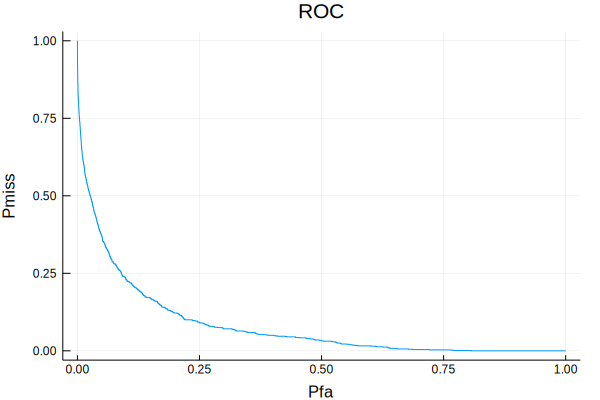

In [9]:
using Plots
plot(r)

The axes of a ROC plot are named "Probability of False Alarm" (false positive rate) and "Probability of Miss" (false negative rate).  There are many names for these (see the `README.md`).  A note about this way of plotting:
 
 - The vertical axis (like the horizontal) is an _error_ rate, and not its complement, the _hit_ rate.  This means that a "good" ROC curve here goes towards the lower left corner, and not the upper left corner.  In literature one traditionally comes across the true positive rate vs. false positive rate, which is an "upper-left" style of ROC. 

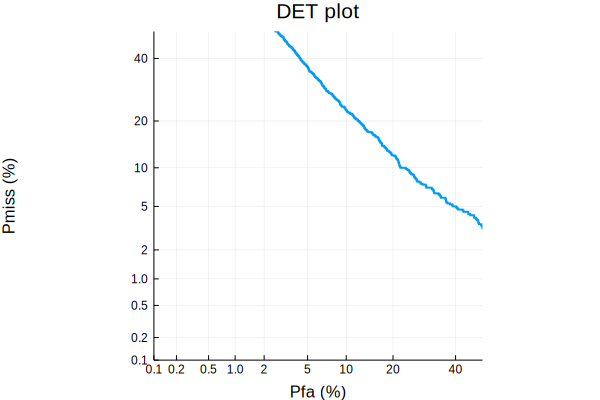

In [10]:
## The "Detection Error Tradeoff" plot, this should give a more/less straight line
detplot(r)

A Detection Error Trade-off plot (DET plot) shows _the same_ information as the ROC plot above---but the scales are warped according to the inverse of the cumulative normal distribution.  This way of plotting has many advantages:

- If the distributions of target and non-target scores are both Normal, then the DET-curve is a straight line.  In practice, many detection problems give rise to more-or-less straight DET curves, and this suggests that there exists a strictly increasing warping function that can make the score distributions (more) Normal. 

- Towards better performance (lower error rates), the resolution of the graph is higher.  This makes it more easy to have multiple systems / performance characteristics over a smaller or wider range of performance in the same graph, and still be able to tell these apart.

- Conventionally, the ranges of the axes are chosen 0.1%--50%---and the plot area should _really_ be square.  This makes it possible to immediately assess the overall performance based on the absolute position of the line in the graph if you have seen more DET plots in your life.

- The slope of the (straight) line corresponds to the ratio of the `σ` parameters of the underlying Normal score distributions, namely that of the non-target scores divided by that of the target scores.  Often, highly discriminative classifiers show very _flat_ curves, indicating that that target scores have a much larger variance than the non-target scores.  

- The origin of this type of plot lies in psychophysics, where graph paper with lines according to this warping was referred to as _double probability paper_.  The diagonal $y=x$ in a DET plot corresponds linearly to a quantity known as $d'$ (d-prime) from psychophysics, ranging from 0 at 50% error to about 6 at 0.1% error. 

In [11]:
## compute the Area Under the ROC, should be close to 0.078
auc(r)

0.08106956

Please note, that traditionally the AUC is the complement of this.  However, in this package all metrics are "error" and "cost" like, so low numbers always indicate better performance.  As a courtesy to all other research fields that work with two-class detectos, we have the convenience function `AUC()`, which---like `auc()`---allows for partial integration up to a certain value of `pfa` or `pmiss`. 

In [12]:
println(AUC(r))
println(AUC(r, pfa=0.1, normalize=false)) ## Traditional AUC integrating pfa from 0 to 0.1
println(AUC(r, pfa=0.1)) ## normalize partial AUC to range 0.5 (no discrimiation) to 1.0 (perfect discrimination)

0.91893044
0.058866930000000005
0.7835101578947368


In [13]:
## define a decision cost function by its parameter p_tar=0.01, Cfa=1, Cmiss=10 (NIST SRE 2008 setting)
d = DCF(0.01, 1, 10)

Ptar = 0.01, Cfa = 1, Cmiss = 10
 prior log-odds = -2.292534757140544
 effective prior odds = 0.10101010101010102
 effective prior = 0.09174311926605504


Decision theory analyses the two types of error that can be made in terms of a cost function, weighting one type of error (say, a criminal that is not sentenced) differently from the other type of error (say, an innocent civilian in sentenced), and a prior for the target hypothesis (the prior that someone is guilty before assessing the evidence).  Theses parameters are called $p_{\rm tar}$, $C_{\rm fa}$ and $C_{\rm miss}$ in this package.  Their joint influence to decision making can be nicely summarized in the _prior log-odds_

In [14]:
## `actual costs' using a threshold of scores at -plo(d) (minus prior log odds)
plo(d)

-2.292534757140544

If the scores are interpretable as _calibrated log-likelihood-ratios_, then the optimal threshold should be at `-plo(DCF)`, the value of the dcf can be computed as:

In [15]:
dcf(tar, non, d=d)

0.07266770000000002

If you know the decision cost function you want to work with and it doesn't change, you can set it default:

In [16]:
setdcf(d=d)

Ptar = 0.01, Cfa = 1, Cmiss = 10
 prior log-odds = -2.292534757140544
 effective prior odds = 0.10101010101010102
 effective prior = 0.09174311926605504


In [17]:
dcf(tar, non)

0.07266770000000002

Perhaps your data requires a different threshold, because the scores have not been calibrated.  

In [18]:
dcf(tar, non, thres=0.)

0.17183790000000004

The decision cost function is a lot higher for this threshold, so the threshold is worse than the default `thres = -plo(d) = 2.29` that is automatically chosen for this DCF.  What is the minimal value of the dcf that can be obtained if we vary the threshold?

In [19]:
mindcf(tar, non, d=d)

0.07218560000000002

The _minimum_ dcf is the value of the decision cost function after choosing the threshold optimally, given the entire ROC is known.  In this case, the data were generated to be _well calibrated_, meaning that the difference between the actual dcf and the mininumum dcf is small. 

The `mindcf` is efficiently calculated by computing the ROC first, so if you still have access to the `Roc` object, you can use it in place of `tar, non` in most of the above functions:

In [20]:
mindcf(r)

0.07218560000000002

Please, note that it is also possible to specify multiple cost functions and store it as a DCF object.  For instance, if you want to scan the behaviour of the dcf when the prior varies:

In [21]:
d = DCF(collect(0.01:0.01:0.99), 1, 1)
mindcf(r, d=d)

99-element Array{Float64,1}:
 0.009362899999999988
 0.01790099999999995 
 0.026064100000000034
 0.03380000000000003 
 0.040778000000000036
 0.04717039999999995 
 0.053338799999999964
 0.05950719999999996 
 0.0652604           
 0.07079600000000001 
 0.07633159999999999 
 0.08182000000000006 
 0.08709390000000007 
 ⋮                   
 0.0830932           
 0.07742299999999998 
 0.07092999999999999 
 0.06443699999999998 
 0.057943999999999954
 0.05145099999999997 
 0.04492060000000004 
 0.03810050000000003 
 0.03128040000000002 
 0.024102700000000015
 0.016119200000000018
 0.008059600000000007

So from this analysis, it seems that at higher and lower priors, the dcf vanishes.  This is true, because at priors close to 0 or 1, the decision can rely more and more on the prior alone, and less on the classifier.  It therefore is interesting to look at what the _normalized_ dcf is.  This is the dcf computed for the classifier scores divided by the dcf based on the prior alone.  In this case, 

In [22]:
mindcf(r, d=d, norm=true)

99-element Array{Float64,1}:
 0.9362899999999987
 0.8950499999999975
 0.8688033333333346
 0.8450000000000005
 0.8155600000000006
 0.7861733333333324
 0.7619828571428565
 0.7438399999999995
 0.7251155555555555
 0.70796           
 0.6939236363636363
 0.6818333333333338
 0.6699530769230775
 ⋮                 
 0.6924433333333334
 0.7038454545454544
 0.7093            
 0.7159666666666666
 0.7242999999999999
 0.7350142857142857
 0.7486766666666665
 0.7620099999999997
 0.78201           
 0.8034233333333332
 0.8059600000000001
 0.8059599999999999

This shows that the _utility_ of the classifier (how much decision costs can be improved) lies in the region of (effective) priors closer to `0.5`.

Instead of the somewhat complicated cost function, which depends on a combination of three parameters $p_{\rm tar}$, $C_{\rm fa}$ and $C_{\rm miss}$, we can analyze the classifier's performance in terms of the critical parameter, the prior-log-odds $\zeta$

$$\zeta = \log\bigl(\dfrac{p_{\rm tar}}{1-p_{\rm tar}} \dfrac{C_{\rm miss}}{C_{\rm fa}}\bigr) $$
   
such a function is the Bayes Error Rate $E_B$

$$E_B = p_{\rm eff} \ p_{\rm miss} + (1-p_{\rm eff}) \ p_{\rm fa}$$

where $p_{\rm eff}$ is the _effective_ prior (a cost-weighted prior, related to $\zeta$), and $p_{\rm fa}$ and $p_{\rm miss}$ are the false alarm and miss rate computed by thresholding the scores `tar` and `non` at the optimal Bayes threshold $-\zeta$. 

In [23]:
ber(tar, non, -2.29)

0.06681109427907031

In [24]:
## now scan the Bayes error rate (similar to the dcf above) for a range of prior log odds, and plot
## This is known as the Applied Probability of Error plot

# temporarily unavailable in moving towards Plots.jl
#apeplot(r)

The red curve corresponds to the _actual_ Bayes Error Rate, given the classifier's scores and the `plo` parameter, the green curve corresponds to the _minimum_ Bayes Error Rate.  This minimum Bayes Error is obtained, for each value of `plo` by shifting the scores until the Bayes Error Rate is minimum.  In this case, because scores were generated as log-likelihood ratios, this minimum is more-or-less equal to the actual `ber`.  The black dotted line is the `ber` of the trivial classifier, that bases the decision on the prior alone (i.e., always decides `true` if `lpo>0`, and `false` otherwise). 

You may appreciate this, by considering scrores that are just twice as big---when we plot the APE plot, the Bayes Error is higher than the minimum value---this is an example of _mis-calibratred_ log-likelihood-ratio scores. 

In [25]:
r2 = roc(2tar, 2non)
#apeplot(r2)

ROC curve with 1671 points, of which 48 on the convex hull

For `abs(lpo)>2.5`, the classifier's log-likelihood-ratio scores are so much off, that Bayes decisions are taken that lead to a _higher_ error than the trivial classifier!

This whole curve of calibration performance as a function of prior can be summarized as proportional to the integral under the red curve, a quantity known as the "Cost of the log-likelihood-ratio", `cllr`:

In [26]:
cllr(2tar, 2non)

0.6362954500728115

In a similar way, the area under the green curve can be computed, and this is a summary of the _discrimination_ performance of the classifier, in the same units (which happen to be "bits") as `cllr`:

In [27]:
mincllr(2tar, 2non)

0.5093391269084526

Another way of viewing the same calibration-over-effective-prior analysis, but that focuses on the utility of the classifier over the trivial classifier, is to show the normalized Bayes error rate:

In [28]:
## Temporarily unavailable
#nbeplot(r)

Again, green and red are minimum and actual normalized Bayes error rates.  The two dashed/dotted curves correspond to the contribution of the false positives and false negatives tot the total normalized error rate.  The `plo` score is chosen asymmetric, because there often are many more non-target trials than target trials, and hence the accuracy of the metric is better.  

Finally, a last graph in this workbook, a plot that show the relation between the actual scores and the optimally calibrated scores (corresponding to the minimum-curves in `nbe` and `ber`).  For well-calibrated log-likelihood-ratio scores this should be a straight line of unit slope.  Let's see what happens for our over-confident llr scores:


In [29]:
##Temporarily unavailable
#llrplot(r2)